In [9]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
#if "DISCO_ROOT_FOLDER" in globals():
#    os.chdir(DISCO_ROOT_FOLDER)
#    sys.path.append(DISCO_ROOT_FOLDER)

/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:148: UserWarning: This is now an optional IPython functionality, using autorestore/DISCO_ROOT_FOLDER requires you to install the `pickleshare` library.
  obj = db["autorestore/" + arg]


In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
colors = {
'blue'       : '#00549F',
'blue_75'    : '#407FB7',
'blue_50'    : '#8EBAE5',
'blue_25'    : '#C7DDF2',
'blue_10'    : '#E8F1FA',

'black'      : '#000000',
'black_75'   : '#646567',
'black_50'   : '#9C9E9F',
'black_25'   : '#CFD1D2',
'black_10'   : '#ECEDED',

'magenta'    : '#E30066',
'magenta_75' : '#E96088',
'magenta_50' : '#F19EB1',
'magenta_25' : '#F9D2DA',
'magenta_10' : '#FDEEF0',

'yellow'     : '#FFED00',
'yellow_75'  : '#FFF055',
'yellow_50'  : '#FFF59B',
'yellow_25'  : '#FFFAD1',
'yellow_10'  : '#FFFDEE',


'petrol'     : '#006165',
'petrol_75'  : '#2D7F83',
'petrol_50'  : '#7DA4A7',
'petrol_25'  : '#BFD0D1',
'petrol_10'  : '#E6ECEC',

'turquoise'    : '#0098A1',
'turquoise_75' : '#00B1B7',
'turquoise_50' : '#89CCCF',
'turquoise_25' : '#CAE7E7',
'turquoise_10' : '#EBF6F6',

'green'      : '#57AB27',
'green_75'   : '#8DC060',
'green_50'   : '#B8D698',
'green_25'   : '#DDEBCE',
'green_10'   : '#F2F7EC',

'lime'       : '#BDCD00',
'lime_75'    : '#D0D95C',
'lime_50'    : '#E0E69A',
'lime_25'    : '#F0F3D0',
'lime_10'    : '#F9FAED',

'orange'     : '#F6A800',
'orange_75'  : '#FABE50',
'orange_50'  : '#FDD48F',
'orange_25'  : '#FEEAC9',
'orange_10'  : '#FFF7EA',

'red'        : '#CC071E',
'red_75'     : '#D85C41',
'red_50'     : '#E69679',
'red_25'     : '#F3CDBB',
'red_10'     : '#FAEBE3',

'bordeaux'   : '#A11035',
'bordeaux_75': '#B65256',
'bordeaux_50': '#CD8B87',
'bordeaux_25': '#E5C5C0',
'bordeaux_10': '#F5E8E5',

'purple'     : '#612158',
'purple_75'  : '#834E75',
'purple_50'  : '#A8859E',
'purple_25'  : '#D2C0CD',
'purple_10'  : '#EDE5EA',

'lila'       : '#7A6FAC',
'lila_75'    : '#9B91C1',
'lila_50'    : '#BCB5D7',
'lila_25'    : '#DEDAEB',
'lila_10'    : '#F2F0F7',
}

def add_noise_(X, l, n_noise, eps, noise_eps, border=0):
    """Add noise to data with at least eps distance to the data."""

    noise = np.empty((n_noise, X.shape[1]))
    noise_too_near = np.array(range(len(noise)))
    while len(noise_too_near) > 0:
        noise[noise_too_near] = np.random.uniform(-50, 50, size=(len(noise_too_near), X.shape[1]))
        nbrs_points = NearestNeighbors(n_neighbors=1).fit(X)
        dists_points = nbrs_points.kneighbors(noise)[0]
        noise_too_near_points = np.where(dists_points < eps)[0]
        nbrs_noise = NearestNeighbors(n_neighbors=2).fit(noise)
        dists_noise = nbrs_noise.kneighbors(noise)[0][:, 1]
        noise_too_near_noise = np.where(dists_noise < noise_eps)[0]
        noise_too_near = np.unique(np.hstack((noise_too_near_points, noise_too_near_noise)))

    X_ = np.vstack((X, noise))
    l_ = np.hstack((l, np.array([-1] * len(noise))))

    return X_, l_

def plot_data(X, l, save_fig=None, save_format="png", show=True, cluster_marker_size=10, cluster_marker_density=1, noise_marker_size=20):
    sns.set_style("white")
    fig = plt.figure()
    cmap = mcolors.ListedColormap([colors["black_50"], colors["bordeaux"], colors["blue"] , colors["lime"], colors["magenta"]])
    plt.scatter(
        X[:, 0][l != -1][::cluster_marker_density],
        X[:, 1][l != -1][::cluster_marker_density],
        s=cluster_marker_size,
        c=l[l != -1][::cluster_marker_density],
        vmin=-1,
        vmax=3,
        cmap=cmap,
    )
    plt.scatter(X[:, 0][l==-1], X[:, 1][l==-1], s=noise_marker_size, c=l[l==-1], vmin=-1, vmax=3, cmap=cmap, marker="+",alpha=0.8)
    plt.xticks([])
    plt.yticks([])
    if save_fig:
        plt.savefig(f"{save_fig}v2.{save_format}", format=save_format, dpi=300, bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
    return fig

def calc_scores(X, l):
    def get_score(eval_metric):
        try:
            return f"{eval_metric.__name__}: {round(eval_metric(X, l), 2)}"
        except:
            pass

    from src.utils.metrics import METRICS
    for name in METRICS.keys():
        METRICS[name].__name__ = name
    results = {}
    for metric in METRICS.values():
        try:
            if metric.__name__ == 'CDBW':
                results[metric.__name__] =round(metric(X, l), 5)#
            else:
                results[metric.__name__] =round(metric(X, l), 2)
        except:
            pass
    return results

In [2]:
# Good Noise

import numpy as np

def add_noise(X, l, n_noise, eps, noise_eps, border=0):
    """Add noise to data with at least eps distance to the data."""

    noise = np.empty((n_noise, X.shape[1]))
    noise_too_near = np.array(range(len(noise)))
    while len(noise_too_near) > 0:
        noise[noise_too_near] = np.random.uniform(
            np.min(X - border, axis=0), np.max(X + border, axis=0), size=(len(noise_too_near), X.shape[1])
        )
        nbrs_points = NearestNeighbors(n_neighbors=1).fit(X)
        dists_points = nbrs_points.kneighbors(noise)[0]
        noise_too_near_points = np.where(dists_points < eps)[0]
        nbrs_noise = NearestNeighbors(n_neighbors=2).fit(noise)
        dists_noise = nbrs_noise.kneighbors(noise)[0][:, 1]
        noise_too_near_noise = np.where(dists_noise < noise_eps)[0]
        noise_too_near = np.unique(np.hstack((noise_too_near_points, noise_too_near_noise)))

    X_ = np.vstack((X, noise))
    l_ = np.hstack((l, np.array([-1] * len(noise))))

    return X_, l_


def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-10, -10], [10, -10], [-10, 10], [10, 10]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    X, l = add_noise_(X, l, n_noise, 2, 0.5, border=0.5)
    return X, l

def relabel_noise(X,l):
    centers = np.array([[-10, -10], [10, -10], [-10, 10], [10, 10]])
    for i, label in enumerate(l):
        if label ==-1:
            coords = X[i]
            if coords[0] >0:
                if coords[1]  >0:
                    # x> 0 y>0
                    l[i]= 3
                else:
                    # x> 0 y<0
                    l[i]= 1
            else:
                if coords[1] >0:
                    # x< 0 y>0
                    l[i]= 2
                else:
                    # x< 0 y<0
                    l[i] = 0


    return l

noises = [0, 200]
good_synth_noise_datasets = [
    make_blob_and_noise_dist_uniform(200, n_noise=n_noise) for n_noise in noises
]

/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

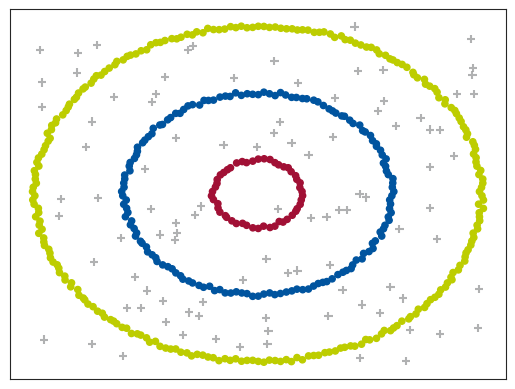

In [3]:
from src.utils.data import add_noise
radii = [5, 15, 25]
n_points_per_cluster = [100, 300, 500]
n_points_per_cluster = [50, 150, 250]

X = np.array(
    [
        [math.sin((2 * math.pi / n_points) * i) * (radius+(np.random.uniform(0,0.6)-0.3)), math.cos((2 * math.pi / n_points) * i) * (radius+(np.random.uniform(0,0.6)-0.3))]
        for radius, n_points in zip(radii, n_points_per_cluster)
        for i in range(n_points)
    ]
)
l = np.array(sum([[c] * n_points for c, n_points in enumerate(n_points_per_cluster)], []))
np.random.seed(0)
X_noise, l_noise = add_noise(X, l, 100, 1.6, 0.6)
# X_noise, l2 = add_noise(X, l1, 70, 0.15, 0.07)

#print(X_noise.shape, l_noise.shape)

fig = plot_data(X_noise, l_noise,save_fig="imgs/Motiv_A_Color",cluster_marker_size=20, noise_marker_size=35, show=False, cluster_marker_density=1)
motiva = calc_scores(X_noise, l_noise)
plt.show()

/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

             Circles  Circles Kmeans
DISCO        0.52000        -0.01000
DBCV         0.77000        -0.90000
DCSI         0.99000         0.01000
LCCV         0.01000         0.30000
VIASCKDE     0.01000         0.01000
CVDD        66.82000         0.50000
CDBW         0.00207         0.00038
CVNN        59.38000        50.57000
SILHOUETTE  -0.15000         0.38000
S_DBW        1.06000         0.81000


/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

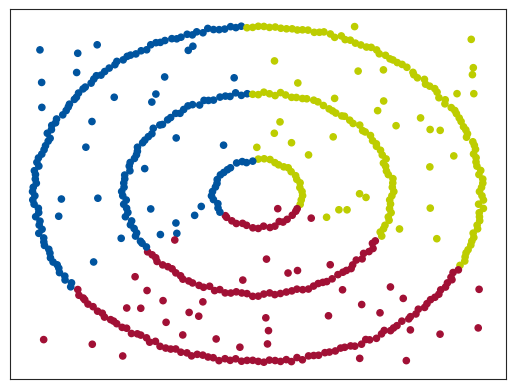

In [4]:
from src.utils.data import add_noise
import pandas as pd
from sklearn.cluster import KMeans

np.random.seed(0)
l_kmeans = KMeans(3).fit_predict(X_noise)

fig = plot_data(X_noise, l_kmeans,save_fig="imgs/Motiv_B_Color",cluster_marker_size=20, noise_marker_size=30, show=False, cluster_marker_density=1)
motivb = calc_scores(X_noise, l_kmeans)

dicts ={'Circles': motiva, 'Circles Kmeans': motivb}
df_motiv = pd.DataFrame(dicts)
with pd.option_context('expand_frame_repr', False):
    print (df_motiv)
plt.show()

In [5]:
def add_noise_(X, l, n_noise, eps, noise_eps, border=0):
    """Add noise to data with at least eps distance to the data."""

    noise = np.empty((n_noise, X.shape[1]))
    noise_too_near = np.array(range(len(noise)))
    while len(noise_too_near) > 0:
        noise[noise_too_near] = np.random.uniform(-50, 50, size=(len(noise_too_near), X.shape[1]))
        nbrs_points = NearestNeighbors(n_neighbors=1).fit(X)
        dists_points = nbrs_points.kneighbors(noise)[0]
        noise_too_near_points = np.where(dists_points < eps)[0]
        nbrs_noise = NearestNeighbors(n_neighbors=2).fit(noise)
        dists_noise = nbrs_noise.kneighbors(noise)[0][:, 1]
        noise_too_near_noise = np.where(dists_noise < noise_eps)[0]
        noise_too_near = np.unique(np.hstack((noise_too_near_points, noise_too_near_noise)))

    X_ = np.vstack((X, noise))
    l_ = np.hstack((l, np.array([-1] * len(noise))))

    return X_, l_

def print_scores(X, l):
    def get_score(eval_metric):
        try:
            return f"{eval_metric.__name__}: {round(eval_metric(X, l), 2)}"
        except:
            pass

    from src.utils.metrics import METRICS
    results = []
    for metric in METRICS.values():
        results.append(get_score(metric))
    # results = []
    for result in results:
        print(result)

/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/src/Evaluation/viasckde.py:37: RuntimeWarning: invalid value encountered in divide
  isos = (isos - min(isos)) / (max(isos) - min(isos))
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/sit

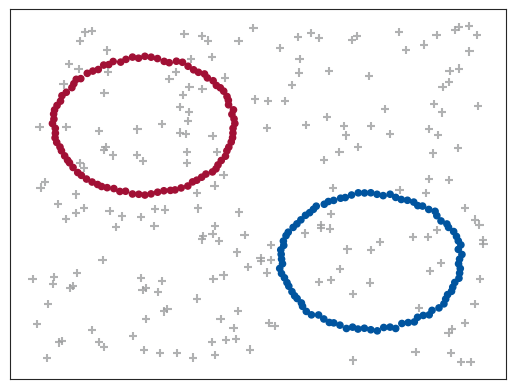

In [6]:
import math
radii = [20,20]
n_points_per_cluster = [ 90, 90]
centers = np.array([[-25, 20], [25, -20]])
corrected_centers = []
X = np.array(
    [
        [math.sin((2 * math.pi / n_points) * i) * (radii[0]+(np.random.uniform(0,1.2)-0.6))+centers[j,0], math.cos((2 * math.pi / n_points) * i) * (radii[1]+(np.random.uniform(0,1.2)-0.6))+centers[j,1]]
        for j, n_points in enumerate(n_points_per_cluster)
        for i in range(n_points)
    ]
)
l = np.array(sum([[c] * n_points for c, n_points in enumerate(n_points_per_cluster)], []))

n_noise =200
X, l = add_noise_(X, l, n_noise, 2, 0.5, border=0.5)
l_1 = l.copy()
radius_incl = 10
for i, label in enumerate(l):
    if label ==-1.0:
        value_c1 = np.linalg.norm(X[i]-centers[0])
        value_c2 = np.linalg.norm(X[i]-centers[1])
        # ausserhalb kleiner Radius
        if  value_c1 >= (radii[0] - radius_incl) :
            # innerhalb größerer Radius
            if value_c1 <= (radii[0] + radius_incl):
                l[i]= 0.
        if value_c2 >= (radii[1] - radius_incl) and value_c2 <= (radii[1] + radius_incl):
            l[i]= 1.
fig = plot_data(X, l_1,save_fig="imgs/Motiv_C_COLOR",cluster_marker_size=20, noise_marker_size=35, show=False, cluster_marker_density=1)

motive = calc_scores(X, l_1)
plt.show()

/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/src/Evaluation/viasckde.py:37: RuntimeWarning: invalid value encountered in divide
  isos = (isos - min(isos)) / (max(isos) - min(isos))


/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

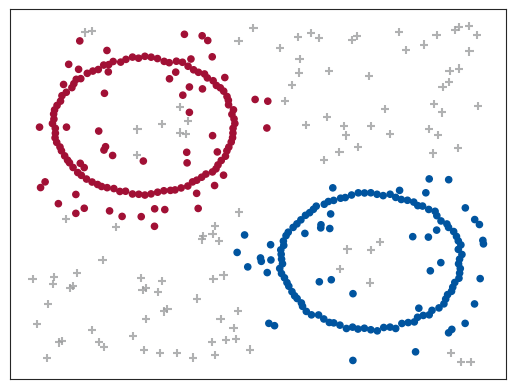

               Good       Bad
DISCO        0.5100   0.19000
DBCV         0.4600   0.63000
DCSI         0.9900   0.94000
LCCV         0.3800   0.40000
VIASCKDE        NaN       NaN
CVDD        37.7400   0.07000
CDBW         0.0016   0.00141
CVNN        54.6700  58.14000
SILHOUETTE   0.0700   0.30000
S_DBW        0.5300   0.55000


In [7]:
fig = plot_data(X, l,save_fig="imgs/Motiv_D_COLOR",cluster_marker_size=20, noise_marker_size=35, show=False, cluster_marker_density=1)

print()
motivf = calc_scores(X, l)
plt.show()
dicts ={'Good': motive, 'Bad': motivf}
df_motiv = pd.DataFrame(dicts)
with pd.option_context('expand_frame_repr', False):
    print (df_motiv)
plt.show()

In [8]:
def plot_data_lines(X, l, save_fig=None, save_format="png", show=True, cluster_marker_size=10, cluster_marker_density=1, noise_marker_size=20):
    fig = plt.figure()
    #cmap = mcolors.ListedColormap([colors["purple"], colors["red"], colors["green"], colors["orange"]])
    #cmap = mcolors.ListedColormap(['dimgray','mediumvioletred', 'orange','navy', 'gold'])#colors["blue"]
    cmap = mcolors.ListedColormap([colors["black_50"], colors["bordeaux"], colors["blue"] , colors["lime"], colors["magenta"]])
    plt.scatter(
        X[:, 0][l != -1][::cluster_marker_density],
        X[:, 1][l != -1][::cluster_marker_density],
        s=cluster_marker_size,
        c=l[l != -1][::cluster_marker_density],
        vmin=-1,
        vmax=3,
        cmap=cmap,
    )
    plt.scatter(X[:, 0][l==-1], X[:, 1][l==-1], s=noise_marker_size, c=l[l==-1], vmin=-1, vmax=3, cmap=cmap, marker="+", alpha=0.8)
    plt.xticks([])
    plt.yticks([])
    if save_fig:
        plt.savefig(f"{save_fig}v2.{save_format}", format=save_format, dpi=300, bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
    return fig


def create_line(n_samples):
    data = np.empty((n_samples, 2))
    labels = np.empty(n_samples)
    for i in range(n_samples):
        x_value = np.random.uniform(-1.5, 1.5)
        if i < int(n_samples/2):
            data[i] = np.array([x_value, np.random.uniform(0.2, 0.3)])
            if x_value <= -0.25:
                labels[i] = 0
            elif x_value <= 0.25:
                labels[i] = -1
            else:
                labels[i] = 1
        else:
            data[i] = np.array([x_value, np.random.uniform(0.0, 0.1)])
            if x_value <= -0.25:
                labels[i] = 2
            elif x_value <= 0.25:
                labels[i] = -1
            else:
                labels[i] = 3
    return data, labels
dolines = False
if dolines:
    X_lines, l_lines_noisy = create_line(4000)
    l_lines = np.array([0]*int(len(X_lines)/2)+[1]*int(len(X_lines)/2))
    fig = plot_data_lines(X_lines, l_lines_noisy,save_fig="imgs/noisy_lines_COLOR_Tab2", cluster_marker_size=2, noise_marker_size=20)
    motiv_noisyline = calc_scores(X_lines, l_lines_noisy)

In [9]:
if dolines:
    fig = plot_data(X_lines, l_lines,save_fig="imgs/lines_COLOR_Tab2", cluster_marker_size=2, noise_marker_size=40)
    motiv_line = calc_scores(X_lines, l_lines)

In [10]:
def colour_2(row):
    if row.name in ['S_DBW','CVNN']:
        if row['No Noise (good)'] <row['No Noise (bad)']:
                colour = 'green'
        elif row['No Noise (good)'] >row['No Noise (bad)']:
                    colour = 'orange'
        else:
            colour = 'grey'
    else:
        if row['No Noise (good)'] >row['No Noise (bad)']:
                colour = 'green'
        elif row['No Noise (good)'] <row['No Noise (bad)']:
                colour = 'orange'
        else:
            colour = 'grey'
    return colour

In [11]:
if dolines:
    dicts ={'No Noise (good)': motiv_line, 'No Noise (bad)': motiv_noisyline}
    df_test2 = pd.DataFrame(dicts)
    df_test2['color'] = df_test2.apply(colour_2, axis=1)
    df_test2  = df_test2.rename(columns={'No Noise (good)': 'Lines', 'No Noise (bad)': 'Noisy lines'})
    #temporaly set expand_frame_repr
    with pd.option_context('expand_frame_repr', False):
        print (df_test2)
        print(df_test2.to_latex())

In [12]:
import seaborn as sns
def plot_data_noise(X, l, save_fig=None, save_format="png", show=False, cluster_marker_size=10, cluster_marker_density=1,
              noise_marker_size=20):
    sns.set_style("white")
    fig = plt.figure()
    cmap = mcolors.ListedColormap([colors["bordeaux"], colors["blue"] , colors["lime"], colors["magenta"], colors["orange"], colors["green"], colors["lila"], colors["yellow"],colors["blue_75"],colors["purple"],colors["petrol"],colors["turquoise"]])
    noise_cmap =mcolors.ListedColormap([colors["black_50"]])
    print(len(np.unique(l)))
    if len(np.unique(l)) == 9:
        cmap = mcolors.ListedColormap([ colors["bordeaux"], colors["blue"] , colors["lime"], colors["magenta"], colors["orange"], colors["green"], colors["lila"], colors["yellow"],colors["blue_75"] ,])
    plt.scatter(
        X[:, 0][l != -1][::cluster_marker_density],
        X[:, 1][l != -1][::cluster_marker_density],
        s=cluster_marker_size,
        c=l[l != -1][::cluster_marker_density],
        vmin=0,
        vmax=len(np.unique(l))-1,
        cmap=cmap,
    )
    plt.scatter(X[:, 0][l == -1], X[:, 1][l == -1], s=noise_marker_size, c=l[l == -1], vmin=-1, vmax=3, cmap=noise_cmap,
                marker="+", alpha=0.8)
    plt.xticks([])
    plt.yticks([])
    if save_fig:
        plt.savefig(f"{save_fig}v2.{save_format}", format=save_format, dpi=300, bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
    return fig

def calc_scores(X, l):
    def get_score(eval_metric):
        try:
            return f"{eval_metric.__name__}: {round(eval_metric(X, l), 2)}"
        except:
            pass

    from src.utils.metrics import METRICS
    for name in METRICS.keys():
        METRICS[name].__name__ = name
    results = {}
    for metric in METRICS.values():
        try:
            if metric.__name__ == 'CDBW':
                results[metric.__name__] =round(metric(X, l), 5)#
            else:
                results[metric.__name__] =round(metric(X, l), 2)
        except:
            pass
    # results = []
    #for result in results:
    #    print(result)
    return results

[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
12


/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

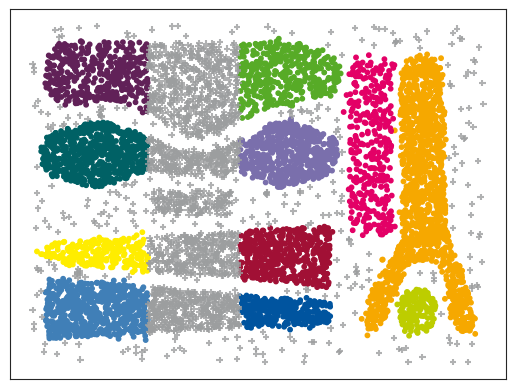

In [13]:
X_clutot8, l_clutot8 = DensityDatasets.cluto_t8_8k.standardized_data_cached

l = l_clutot8.copy()

l[np.logical_and(X_clutot8[:,0]<-0.05, X_clutot8[:,0]>-0.8)]=-1
for label in np.unique(l):
    if label ==-1:
        continue
    else:
        #logical_smaller = np.logical_and(l==label, X_clutot8[:,0]>-0.05)
        logical_larger = np.logical_and(l==label, X_clutot8[:,0]<-0.8)
        if np.any(logical_larger):
            l[logical_larger]=label+8
cluster_label=-1
for label in np.unique(l):
    l[l==label] = cluster_label
    cluster_label+=1
print(np.unique(l))

plot_data_noise(X_clutot8, l, save_fig='imgs/Cluto_noiseline')
noisy_cluto = calc_scores(X_clutot8, l)

9


/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lena/Documents/Projects/PycharmProjects/DISCO/.venv/lib/python3.12/site-packages/

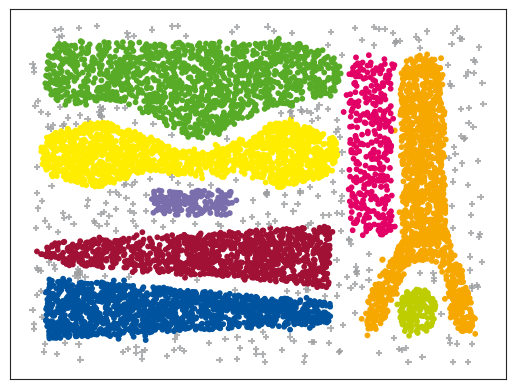

In [14]:
plot_data_noise(X_clutot8, l_clutot8, save_fig='imgs/Cluto_normal')
normal_cluto = calc_scores(X_clutot8, l_clutot8)

In [16]:
def colour_2(row):
    if row.name in ['S_DBW','CVNN']:
        if row['Good'] <row['Bad']:
                colour = 'green'
        elif row['Good'] >row['Bad']:
                    colour = 'orange'
        else:
            colour = 'grey'
    else:
        if row['Good'] >row['Bad']:
                colour = 'green'
        elif row['Good'] <row['Bad']:
                colour = 'orange'
        else:
            colour = 'grey'
    return colour

import pandas as pd
dicts ={'Good': normal_cluto, 'Bad': noisy_cluto}
df_motiv = pd.DataFrame(dicts)
df_motiv['color'] = df_motiv.apply(colour_2, axis=1)
with pd.option_context('expand_frame_repr', False):
    print (df_motiv)

               Good     Bad   color
DISCO       0.30000 -0.0700   green
DBCV       -0.05000  0.1700  orange
DCSI        0.92000  0.9600  orange
LCCV        0.11000  0.2600  orange
VIASCKDE    0.66000  0.6500   green
CVDD        0.07000  0.1500  orange
CDBW        0.15602  0.5646  orange
CVNN        5.59000  4.8600  orange
SILHOUETTE  0.06000  0.0900  orange
S_DBW       0.73000  0.3100  orange
